In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import cv2
%matplotlib inline

PATH = '/home/karti/sdc-live-trainer/data/'
BATCH = 512
IMG_ROWS = 80
IMG_COLS = 320
IMG_CH = 3
OFF_CENTER_IMG_ANGLE = .25
TRANS_Y_RANGE = 20
TRANS_X_RANGE = 50
ANGLE_BIAS = .5
ANGLE_PER_TRANS = .1
BRIGHTNESS_RANGE = .1

In [2]:
"""
READ THE DATA
"""
df = pd.read_csv(os.path.join(PATH,'driving_log.csv'))

In [ ]:
"""
PLOT THE ANGLES DIRECTLY
"""
plt.bar(df.steering.index, df.steering.values, width=0.01)
plt.show()

In [ ]:
"""
PLOT THE HISTOGRAM
"""
hist = df.steering.value_counts()
plt.bar(hist.index, hist.values, width=0.01)
plt.show()

In [ ]:
"""
Randomly showcase some of the images for each angle
"""
fig = plt.figure(figsize=(60, 60))
gs = gridspec.GridSpec(21, 3)

# Plot one of the 0 values

for i in range(21):
    panel = df.loc[df.steering >= -1 + (i/10)]
    ans = panel.loc[panel.steering < -1 + ((i+1)/10)]
    #print (ans.steering.iloc[0])
    if len(ans):
        for j in range(3):
            idx = np.random.choice(ans.index)
            img = cv2.imread(os.path.join(PATH, ans.center[idx].strip()))
            ax = fig.add_subplot(gs[(i*5)+j])
            ax.set_title(ans.steering[idx])
            ax.imshow(img)

gs.tight_layout(fig)
plt.show()

In [3]:
"""
Preprocessing function
"""
def img_pre_process(img):
    """
    Processes the image and returns it
    :param img: The image to be processed
    :param draw: If the images should be drawn for debug
    :return: Returns the processed image
    """
    # Remove the unwanted top scene and retain only the track
    roi = img[60:140,:,:]

    norm = (roi / 255.) - .5

    return norm


def img_change_brightness(img):
    # Convert the image to HSV
    temp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Compute a random brightness value and apply it to the image
    brightness = BRIGHTNESS_RANGE + np.random.uniform() - 0.5
    temp[:, :, 2] = temp[:, :, 2] * brightness

    # Convert back to RGB and return
    return cv2.cvtColor(temp, cv2.COLOR_HSV2RGB)


def img_translate(img, x_translation):
    # Randomly compute a Y translation
    y_translation = (TRANS_Y_RANGE * np.random.uniform()) - (TRANS_Y_RANGE / 2)

    # Form the translation matrix
    translation_matrix = np.float32([[1, 0, x_translation], [0, 1, y_translation]])

    # Translate the image
    return cv2.warpAffine(img, translation_matrix, (img.shape[1], img.shape[0]))


def data_augment(img_path, angle, threshold):
    # Randomly form the X translation distance and compute the resulting steering angle change
    x_translation = (TRANS_X_RANGE * np.random.uniform()) - (TRANS_X_RANGE / 2)
    new_angle = angle + ((x_translation / TRANS_X_RANGE) * 2) * ANGLE_PER_TRANS

    # Check if the new angle does not meets the threshold requirements
    if (abs(new_angle) + ANGLE_BIAS) < threshold:
        return None, None

    # Hurray, the newly generated angle matches the threshold
    img = cv2.imread(img_path)
    img = img_change_brightness(img)
    img = img_translate(img, x_translation)
    img = img_pre_process(img)

    # Finally, lets' decide if we want to flip the image or not
    if np.random.randint(2) == 0:
        return img, new_angle
    return np.fliplr(img), -new_angle

In [4]:
def train_data_generator(df):
    """
    Training data generator
    :param df: Pandas data frame consisting of all the training data
    :return: (x[BATCH, IMG_ROWS, IMG_COLS, NUM_CH], y)
    """
    _x = np.zeros((BATCH, IMG_ROWS, IMG_COLS, IMG_CH), dtype=np.float)
    _y = np.zeros(BATCH, dtype=np.float)
    out_idx = 0
    while 1:
        # Get a random line and get the steering angle
        idx = np.random.randint(len(df))
        angle = df.steering.iloc[idx]

        # Pick one of the images, left, right or center
        img_choice = np.random.randint(3)
        if img_choice == 0:
            img_path = os.path.join(PATH, df.left.iloc[idx].strip())
            angle += OFF_CENTER_IMG_ANGLE
        elif img_choice == 1:
            img_path = os.path.join(PATH, df.center.iloc[idx].strip())
        else:
            img_path = os.path.join(PATH, df.right.iloc[idx].strip())
            angle -= OFF_CENTER_IMG_ANGLE

        """
        Randomly distort the (img, angle) to generate new data
        Here, we want to bias towards not selecting low angles, so we generate a random number
        and if that number were less than the absolute value of the newly coined angle + a known bias,
        only then do we accept the transformation.
        """
        threshold = np.random.uniform()
        img, angle = data_augment(img_path, angle, threshold)

        # Check if we've got valid values
        if img is not None:
            _x[out_idx] = img
            _y[out_idx] = angle
            out_idx += 1

        # Check if we've enough values to yield
        if out_idx >= BATCH:
            yield _x, _y

            # Reset the values back
            _x = np.zeros((BATCH, IMG_ROWS, IMG_COLS, IMG_CH), dtype=np.float)
            _y = np.zeros(BATCH, dtype=np.float)
            out_idx = 0

In [5]:
# Generate one EPOCH worth data
my_x = np.zeros((31,3,80,320,3), dtype=np.float)
my_x_idx = np.zeros(31, dtype=np.int)

my_y = np.zeros(512*1, dtype=np.float)
my_y_idx = 0

for x,y in train_data_generator(df):
    for idx in np.arange(y.shape[0]):
        my_y[my_y_idx] = y[idx]
        my_y_idx += 1
        
        slot = int(y[idx]*10 + 15)
        if my_x_idx[slot] < 3:
            my_x[slot][my_x_idx[slot]] = np.copy(x[idx])
            my_x_idx[slot] += 1
        
    if my_y_idx >= 512*1:
        break

In [6]:
print (my_x_idx)

[0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 0 0 0 1 0 0 0 0]


<Container object of 100 artists>

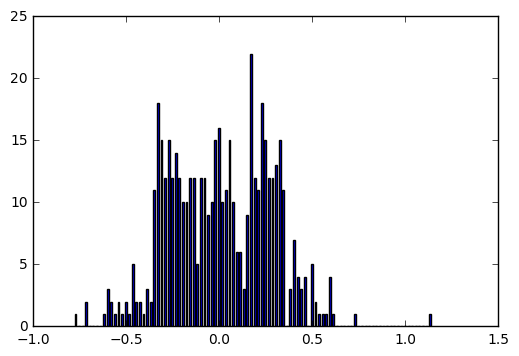

In [7]:
"""
Plot histogram of generated data
"""
hist = np.histogram(my_y, 100)
plt.bar(hist[1][:100], hist[0], width=0.01)

In [ ]:
print (my_x[10][2])

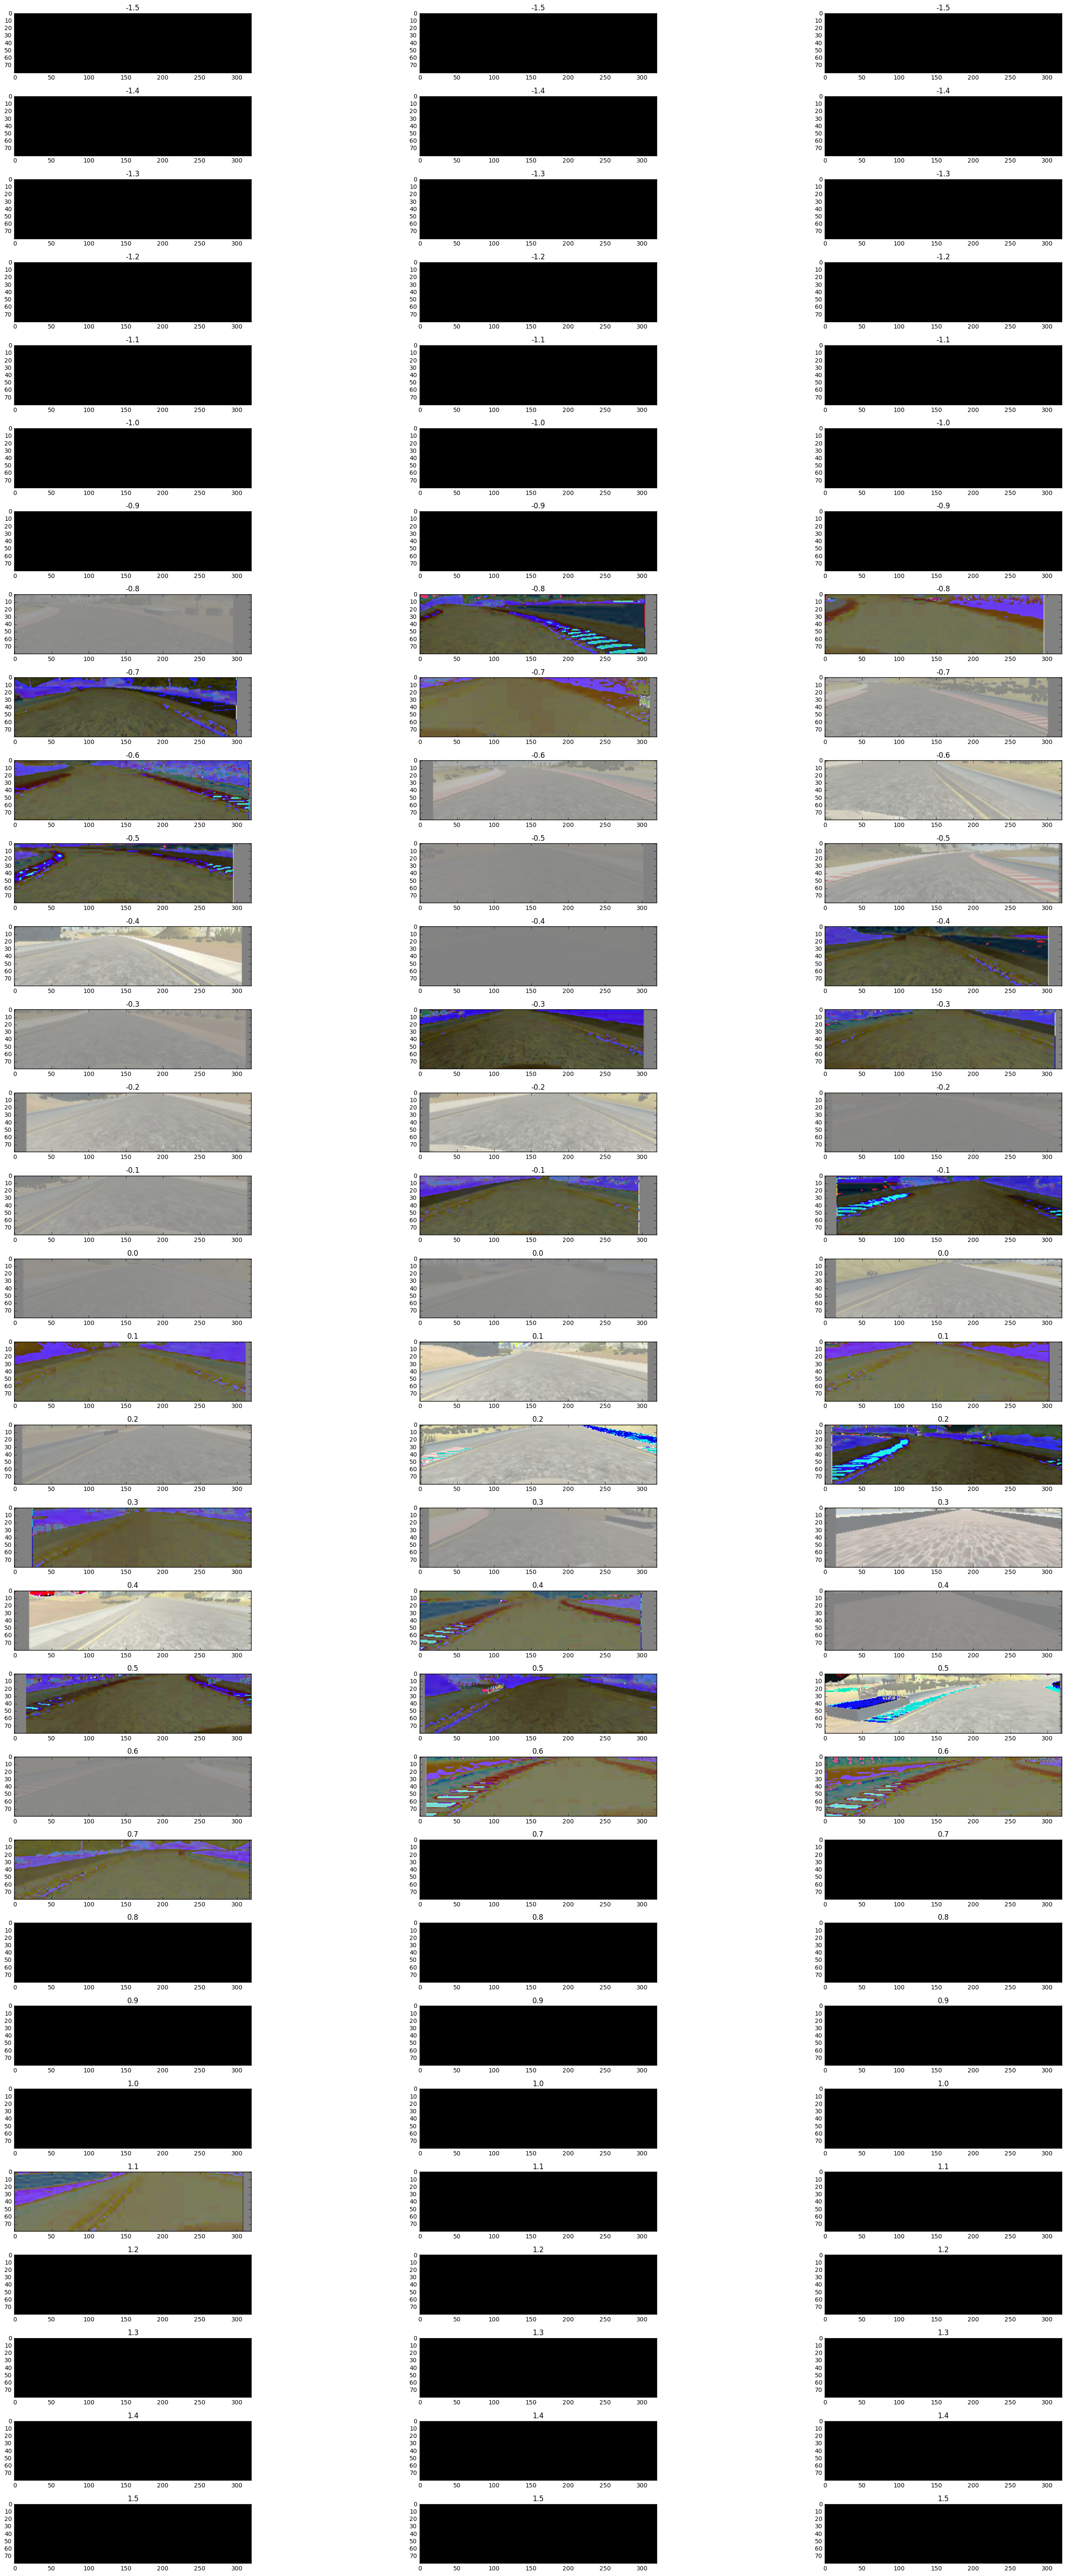

In [8]:
"""
Show the generated images for each slot
"""
fig = plt.figure(figsize=(30, 60))
gs = gridspec.GridSpec(31, 3)

# Plot one of the 0 values

for i in range(len(my_x_idx)):
    for j in range(3):
        ax = fig.add_subplot(gs[(i*3)+j])
        ax.set_title((i - 15) / 10)
        ax.imshow(my_x[i][j])

gs.tight_layout(fig)
plt.show()